In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import expm, eigh  # Use scipy for the matrix exponential function

class Simulator:
    def __init__(self, N, H):
        self.N = N
        self.H = H
    
    def compute_eigenvalues(self):
        """Compute all possible eigenvalues of the Hamiltonian."""
        eigenvalues = set()
        for config in range(1 << self.N):
            spins = [1 if (config & (1 << i)) else -1 for i in range(self.N)]
            eigenvalue = self.H(spins)
            eigenvalues.add(eigenvalue)
        return sorted(eigenvalues)
    
    def suggest_t(self):
        """Suggest an optimal time t based on the energy gap."""
        eigenvalues = self.compute_eigenvalues()
        if len(eigenvalues) < 2:
            raise ValueError("Insufficient eigenvalues to compute energy gap.")

        gaps = [eigenvalues[i + 1] - eigenvalues[i] for i in range(len(eigenvalues) - 1)]
        delta_E = min(gaps)
        return 1 / delta_E  # Suggest t proportional to the inverse gap
    
    def adiabatic_evolution(simulator, num_steps=100, T=10):
        """
        Simulates adiabatic evolution with a transverse field as the initial Hamiltonian.

        Parameters:
        - simulator: Simulator instance with target Hamiltonian.
        - num_steps: Number of steps in the evolution.
        - T: Total time for the adiabatic process.

        Returns:
        - probabilities_over_time: List of transition probabilities at each step.
        """
        num_states = 2**simulator.N
        H_initial = np.zeros((num_states, num_states), dtype=complex)

        # Construct the transverse field Hamiltonian
        for i in range(simulator.N):
            for config in range(num_states):
                flipped_config = config ^ (1 << i)  # Flip the i-th spin
                H_initial[config, flipped_config] = -1  # Pauli-X equivalent

        H_final = np.zeros((num_states, num_states), dtype=complex)

        # Construct the target (final) Hamiltonian matrix
        for config in range(num_states):
            spins = [1 if (config & (1 << i)) else -1 for i in range(simulator.N)]
            energy = simulator.H(spins)
            H_final[config, config] = energy

        # Adiabatic evolution
        H_ts_over_time = []
        states_over_time = []
        time_points = np.linspace(0, T, num_steps)
        current_state = np.ones(num_states, dtype=complex) / np.sqrt(num_states)  # Initial state

        for t in time_points:
            s = t / T
            H_t = (1 - s) * H_initial + s * H_final  # Interpolate between initial and final Hamiltonians
            #print(f"Time: {t:.2f}, Matrix size: {H_t.shape}")
            H_ts_over_time.append((t, H_t))
            U = expm(-1j * H_t * (T / num_steps))  # Evolution operator for small step
            current_state = U @ current_state  # Apply the evolution
    
            states_over_time.append((t, current_state))
        return states_over_time, H_ts_over_time


In [11]:
def plot_adiabatic_evolution(simulator, num_steps=200, T=1, title="Adiabatic Evolution with Transverse Initial Hamiltonian"):
    """
    Simulates adiabatic evolution with a transverse field initial Hamiltonian and plots the state probabilities over time.
    Labels only the state with the highest final probability.
    """
    states, _ = sim.adiabatic_evolution(num_steps, T)

    probabilities_over_time = []
    for t, state in states:
        probabilities = np.abs(state)**2
        probabilities_over_time.append((t, probabilities))

    # Extract time points and state probabilities
    time_points = [entry[0] for entry in probabilities_over_time]
    state_probabilities = np.array([entry[1] for entry in probabilities_over_time])
    state_labels = [bin(config)[2:].zfill(simulator.N) for config in range(state_probabilities.shape[1])]

    # Find the state with the highest final probability
    highest_probability_idx = np.argmax(state_probabilities[-1])  # Index of the highest probability state
    highest_state_label = state_labels[highest_probability_idx]
    highest_probability = state_probabilities[-1, highest_probability_idx]

    # Assign unique colors
    colors = cm.viridis(np.linspace(0, 1, len(state_labels)))

    # Plot the results
    plt.figure(figsize=(12, 6))
    for state_idx, state_label in enumerate(state_labels):
        plt.plot(time_points, state_probabilities[:, state_idx], color=colors[state_idx])
        if state_idx == highest_probability_idx:
            # Add the label for the highest probability state
            plt.text(
                time_points[-1],  # Last time point
                state_probabilities[-1, state_idx],  # Probability at the last time point
                f"ψ={highest_state_label}, P={highest_probability:.2f}",  # Detailed label with probability
                fontsize=10,  # Font size for the text
                color=colors[state_idx],  # Match the line color
                verticalalignment='center',  # Align the label vertically with the line
            )

    plt.xlabel("Time (t)")
    plt.ylabel("Probabilities")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [12]:
def plot_eigenvalue_evolution(simulator, num_steps=200, T=1, title="Eigenvalue Evolution During Adiabatic Process"):
    """
    Simulates adiabatic evolution and plots the unique eigenvalues over time.
    Labels only the line with the lowest ending eigenvalue with its spin configuration and eigenvalue.
    """
    all_eigenvalues = []
    states, H_ts = simulator.adiabatic_evolution(num_steps, T)

    for t, H_t in H_ts:
        eigenvalues = eigh(H_t, eigvals_only=True)
        all_eigenvalues.append((t, eigenvalues))

    time_points = [entry[0] for entry in all_eigenvalues]
    all_eigenvalues = np.array([entry[1] for entry in all_eigenvalues])

    # Assign unique colors for eigenvalue trajectories
    colors = cm.viridis(np.linspace(0, 1, all_eigenvalues.shape[1]))

    # Find the trajectory of the lowest energy state at the final time step
    lowest_energy_idx = np.argmin(all_eigenvalues[-1])  # Index of the lowest eigenvalue at the last time step
    lowest_eigenvalue = all_eigenvalues[-1, lowest_energy_idx]  # Lowest eigenvalue at the end

    # Extract the final state vector and identify the dominant spin configuration
    final_state_vector = states[-1][1]  # Final state vector at the last time step
    probabilities = np.abs(final_state_vector)**2  # Probabilities of each spin configuration
    dominant_config_idx = np.argmax(probabilities)  # Index of the dominant configuration
    dominant_spin_config = bin(dominant_config_idx)[2:].zfill(simulator.N)  # Binary spin configuration

    # Plot the results
    plt.figure(figsize=(10, 6))
    for idx in range(all_eigenvalues.shape[1]):
        plt.plot(time_points, all_eigenvalues[:, idx], color=colors[idx])
        if idx == lowest_energy_idx:
            # Label the lowest eigenvalue trajectory
            plt.text(
                time_points[-1],  # Last time point
                all_eigenvalues[-1, idx],  # Eigenvalue at the last time point
                f"ψ={dominant_spin_config}, λ={lowest_eigenvalue:.2f}",  # Spin configuration and eigenvalue
                fontsize=10,
                color=colors[idx],
                verticalalignment='center',
            )

    plt.xlabel("Time (t)")
    plt.ylabel("Energy (Eigenvalue)")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


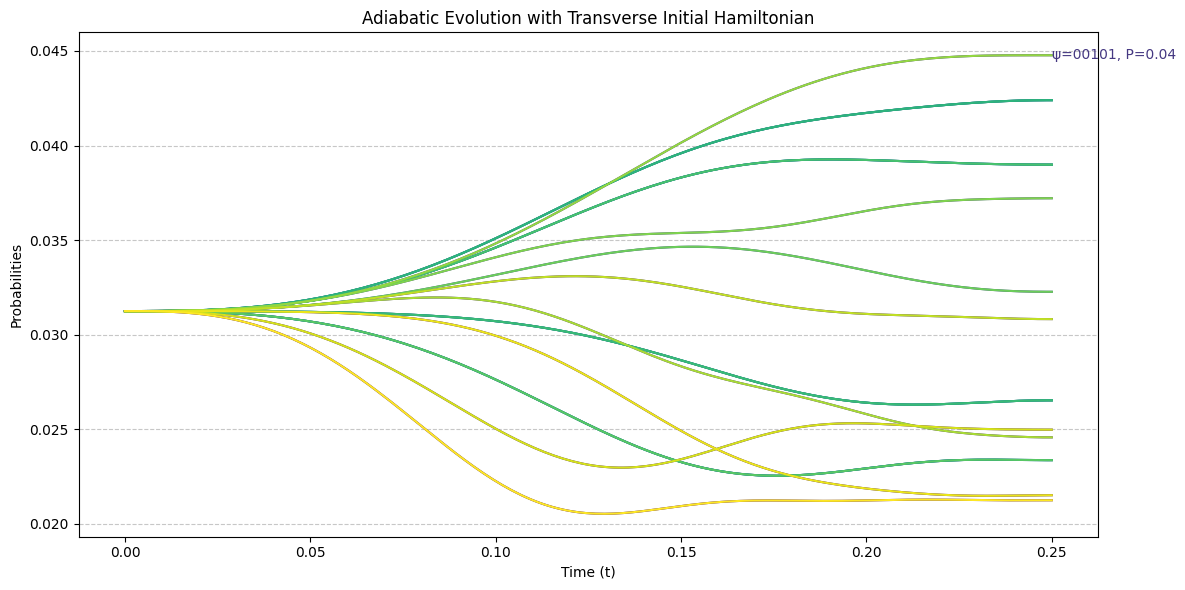

In [13]:
class NumberPartitioning:
    def __init__(self, numbers):
        self.numbers = numbers
    
    def hamiltonian(self):
        """Define the Ising Hamiltonian for the problem."""
        # H = A * (sum(n_i * s_i))^2
        return lambda spins: (np.sum(np.array(self.numbers) * np.array(spins))) ** 2
    
numbers = [3, 1, 4, 2, 2]
np_problem = NumberPartitioning(numbers)
sim = Simulator(len(numbers), np_problem.hamiltonian())

# Compute eigenvalues and suggest optimal t
optimal_t = sim.suggest_t()

# Example usage
plot_adiabatic_evolution(sim, num_steps=200, T=optimal_t)

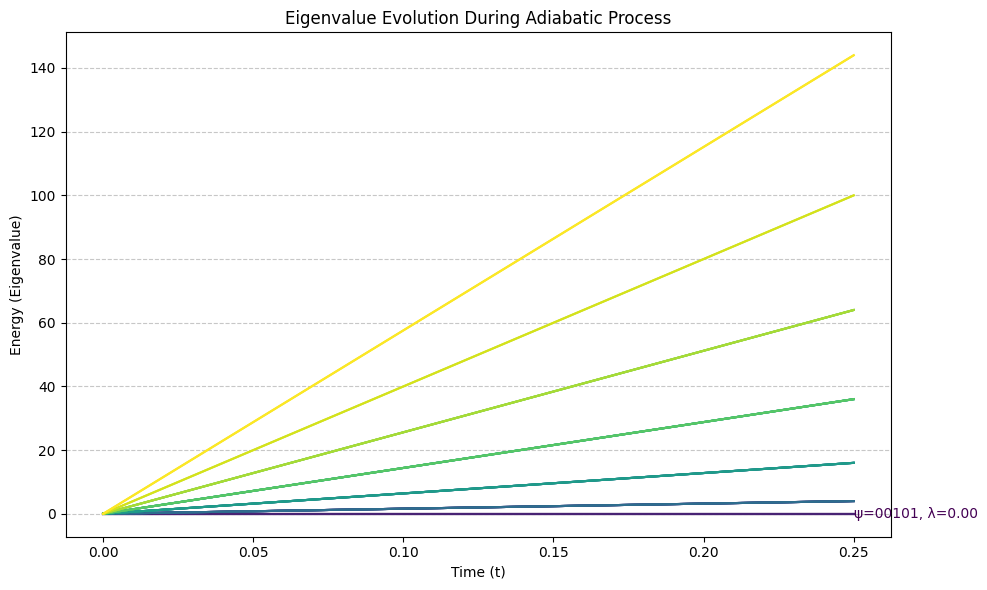

In [9]:
plot_eigenvalue_evolution(sim, num_steps=200, T=optimal_t)

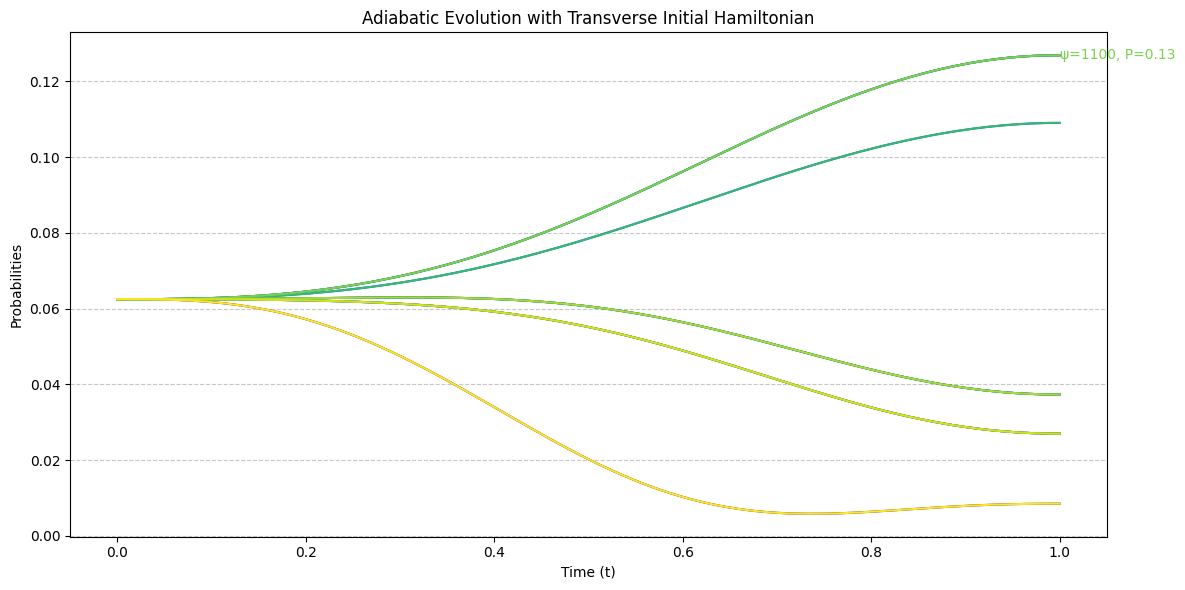

In [163]:
class GraphPartitioning:
    def __init__(self, edges):
        self.edges = edges  # List of tuples representing edges [(u, v), ...]

    def hamiltonian(self):
        """Define the Ising Hamiltonian for graph partitioning."""
        def hamiltonian(spins):
            # First term: size constraint
            term1 = (np.sum(spins)) ** 2
            
            # Second term: edge penalty
            term2 = sum((1 - spins[u] * spins[v]) / 2 for u, v in self.edges)
            
            # Combine terms
            A, B = 1.0, 1.0  # Weights for terms
            return A * term1 + B * term2
        return hamiltonian


# Example Input
edges = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)]  # Example graph (a square with a diagonal)
num_vertices = 4
gp_problem = GraphPartitioning(edges)

sim = Simulator(num_vertices, gp_problem.hamiltonian())

optimal_t = sim.suggest_t()

plot_adiabatic_evolution(sim, num_steps=200, T=optimal_t)

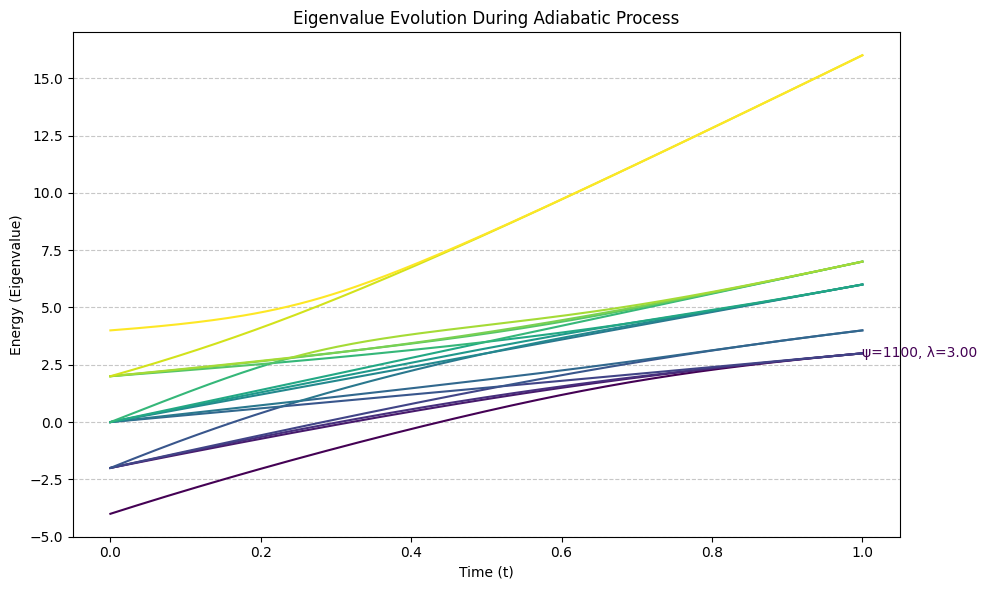

In [164]:
plot_eigenvalue_evolution(sim, num_steps=200, T=optimal_t)

Time: 0.00, Matrix size: (16, 16)
Time: 0.00, Matrix size: (16, 16)
Time: 0.01, Matrix size: (16, 16)
Time: 0.01, Matrix size: (16, 16)
Time: 0.01, Matrix size: (16, 16)
Time: 0.01, Matrix size: (16, 16)
Time: 0.02, Matrix size: (16, 16)
Time: 0.02, Matrix size: (16, 16)
Time: 0.02, Matrix size: (16, 16)
Time: 0.02, Matrix size: (16, 16)
Time: 0.03, Matrix size: (16, 16)
Time: 0.03, Matrix size: (16, 16)
Time: 0.03, Matrix size: (16, 16)
Time: 0.03, Matrix size: (16, 16)
Time: 0.04, Matrix size: (16, 16)
Time: 0.04, Matrix size: (16, 16)
Time: 0.04, Matrix size: (16, 16)
Time: 0.04, Matrix size: (16, 16)
Time: 0.05, Matrix size: (16, 16)
Time: 0.05, Matrix size: (16, 16)
Time: 0.05, Matrix size: (16, 16)
Time: 0.05, Matrix size: (16, 16)
Time: 0.06, Matrix size: (16, 16)
Time: 0.06, Matrix size: (16, 16)
Time: 0.06, Matrix size: (16, 16)
Time: 0.06, Matrix size: (16, 16)
Time: 0.07, Matrix size: (16, 16)
Time: 0.07, Matrix size: (16, 16)
Time: 0.07, Matrix size: (16, 16)
Time: 0.07, Ma

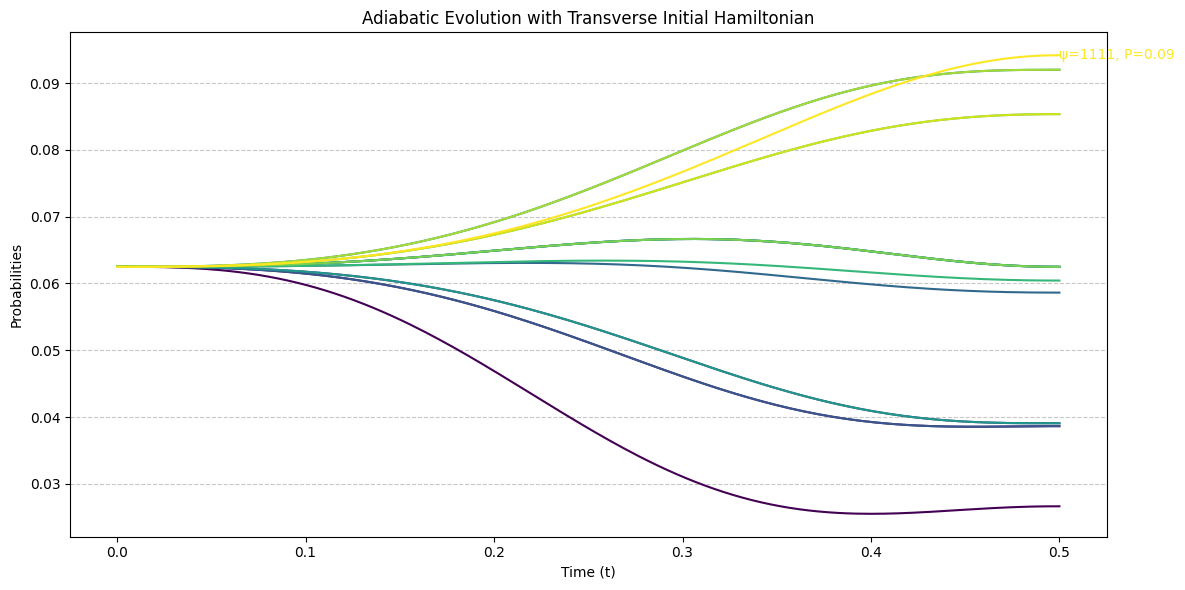

In [170]:
class Cliques:
    def __init__(self, edges, k):
        self.edges = edges  # List of tuples representing edges [(u, v), ...]
        self.k = k  # Desired clique size

    def hamiltonian(self):
        """Define the Ising Hamiltonian for the clique problem."""
        def hamiltonian(spins):
            # First term: enforce clique size
            term1 = (self.k - np.sum(spins)) ** 2
            
            # Second term: enforce clique completeness
            term2 = (self.k * (self.k - 1)) / 2 - sum(
                spins[u] * spins[v] for u, v in self.edges
            )
            
            # Combine terms
            A, B = 1.0, 1.0  # Weights for terms
            return A * term1 + B * term2
        
        return hamiltonian
    
# Example Input
edges = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)]  # Example graph
num_vertices = 4
k = 3  # Desired clique size
cliques_problem = Cliques(edges, k)

sim = Simulator(num_vertices, cliques_problem.hamiltonian())

optimal_t = sim.suggest_t()

plot_adiabatic_evolution(sim, num_steps=200, T=optimal_t)

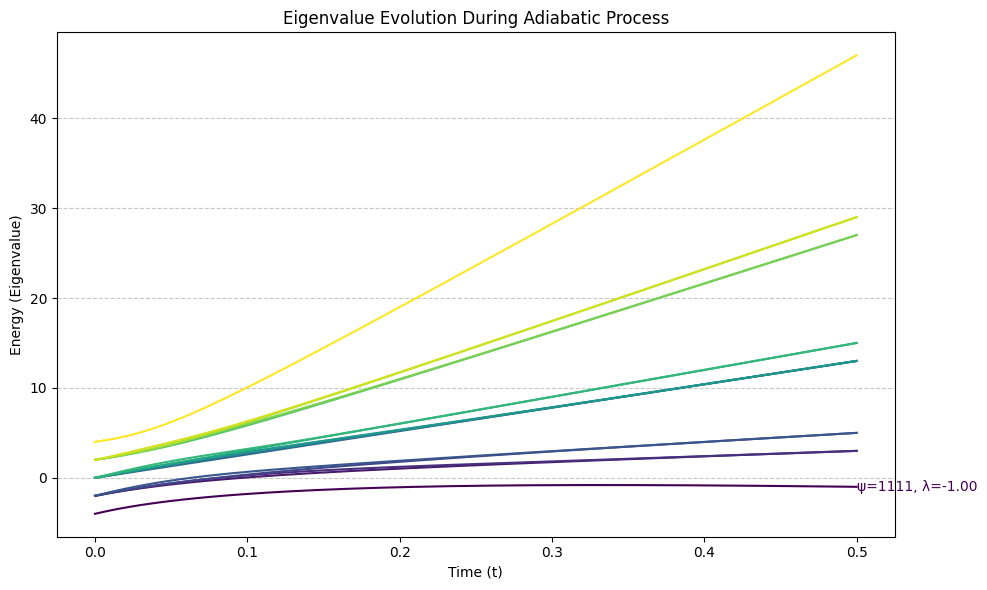

In [166]:
plot_eigenvalue_evolution(sim, num_steps=200, T=optimal_t)